Overall Metrics:
Average Handle Time (AHT): 1134.12 seconds
Average Speed to Answer (AST): 437.07 seconds

Metrics by Primary Call Reason:
        primary_call_reason          AHT         AST
0                   Baggage   871.395349  542.093023
1                   Baggage   876.330275  541.880734
2                 Baggage     866.769231  546.461538
3                   Booking   665.979143  240.278100
4                 Booking     775.000000  237.500000
5                  Check In   917.454545  362.181818
6                  Check-In   930.523490  354.241611
7                Check-In    1067.586207  353.793103
8                  Checkout  1733.380435  725.021739
9                Checkout    2055.000000  712.500000
10           Communications  1066.774279  239.920614
11         Communications    1061.311475  242.950820
12        Digital   Support   856.323529  501.617647
13         Digital  Support   844.800000  503.200000
14          Digital Support   884.819277  506.506024
15        Dig

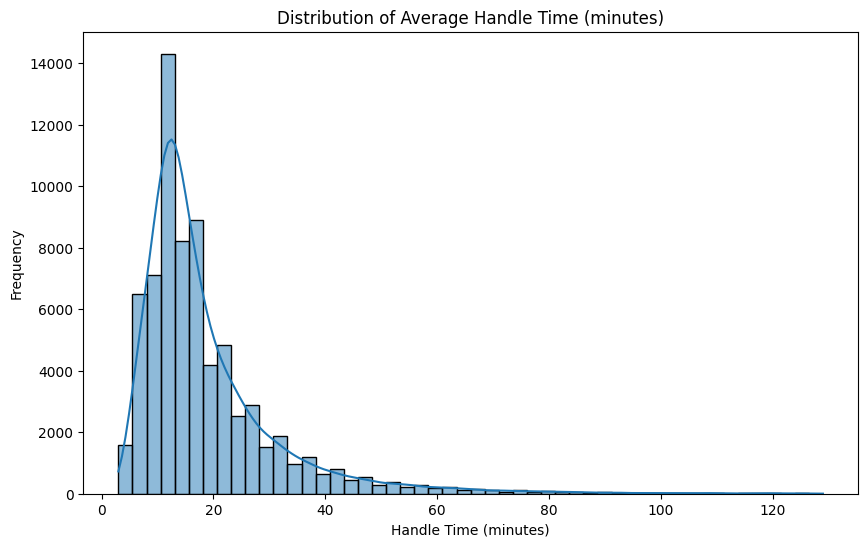

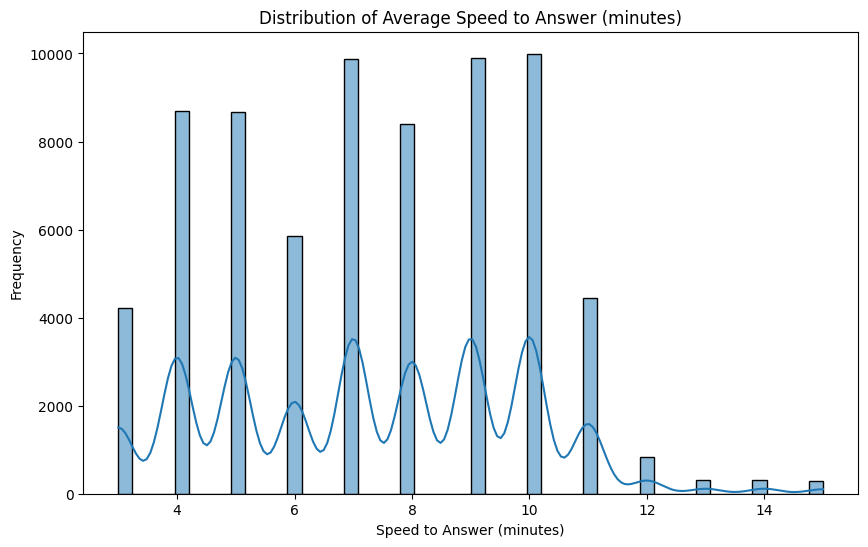

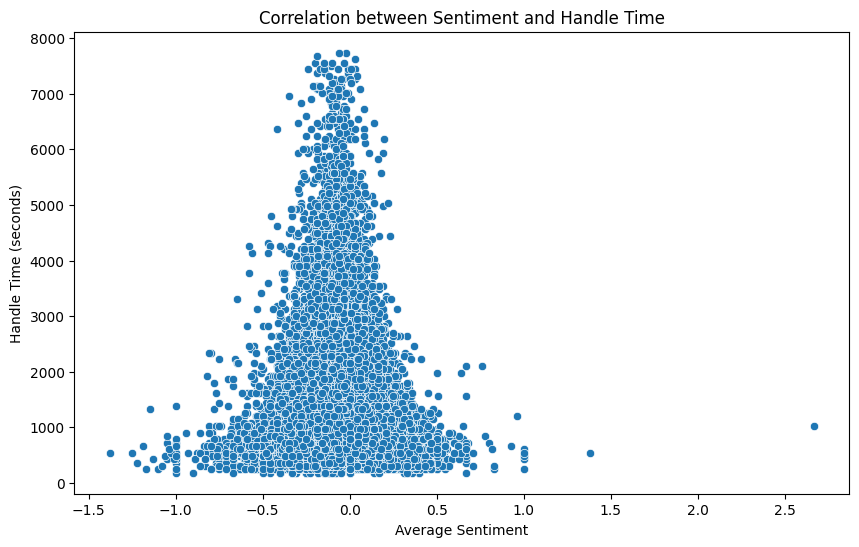

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
calls_df = pd.read_csv("C:\\Users\\me\\Desktop\\Skyline\\calls.csv.csv")
customers_df = pd.read_csv("C:\\Users\\me\\Desktop\\Skyline\\customers.csv.csv")
reason_df = pd.read_csv("C:\\Users\\me\\Desktop\\Skyline\\reason.csv.csv")
sentiment_df = pd.read_csv("C:\\Users\\me\\Desktop\\Skyline\\sentiment_statistics.csv.csv")

# Convert datetime columns to datetime objects
calls_df['call_start_datetime'] = pd.to_datetime(calls_df['call_start_datetime'])
calls_df['agent_assigned_datetime'] = pd.to_datetime(calls_df['agent_assigned_datetime'])
calls_df['call_end_datetime'] = pd.to_datetime(calls_df['call_end_datetime'])

# Calculate handle time and speed to answer
calls_df['handle_time'] = (calls_df['call_end_datetime'] - calls_df['call_start_datetime']).dt.total_seconds()
calls_df['speed_to_answer'] = (calls_df['agent_assigned_datetime'] - calls_df['call_start_datetime']).dt.total_seconds()

# Overall AHT and AST
overall_metrics = {
    'AHT': calls_df['handle_time'].mean(),
    'AST': calls_df['speed_to_answer'].mean()
}
print("Overall Metrics:")
print(f"Average Handle Time (AHT): {overall_metrics['AHT']:.2f} seconds")
print(f"Average Speed to Answer (AST): {overall_metrics['AST']:.2f} seconds")

# AHT and AST by primary call reason
calls_with_reason = calls_df.merge(reason_df, on='call_id', how='left')
reason_metrics = calls_with_reason.groupby('primary_call_reason').agg(
    AHT=('handle_time', 'mean'),
    AST=('speed_to_answer', 'mean')
).reset_index()
print("\nMetrics by Primary Call Reason:")
print(reason_metrics)

# Identify most and least frequent call reasons
reason_counts = calls_with_reason['primary_call_reason'].value_counts()
most_frequent_reason = reason_counts.idxmax()
least_frequent_reason = reason_counts.idxmin()

# Print the reason metrics to debug
print("\nReason Metrics DataFrame:")
print(reason_metrics)

# Use .loc with a condition to avoid KeyError
most_frequent_aht = reason_metrics.loc[reason_metrics['primary_call_reason'] == most_frequent_reason, 'AHT'].values[0]
least_frequent_aht = reason_metrics.loc[reason_metrics['primary_call_reason'] == least_frequent_reason, 'AHT'].values[0]

aht_difference_percentage = ((most_frequent_aht - least_frequent_aht) / least_frequent_aht) * 100
print(f"\nPercentage difference in AHT between most frequent ({most_frequent_reason}) and 
least frequent ({least_frequent_reason}) call reasons: {aht_difference_percentage:.2f}%")

# Analyze self-solvable issues
def analyze_self_solvable_issues(df):
    # Assuming self-solvable issues are those with lower handle times
    potential_self_solvable = df[df['handle_time'] < df['handle_time'].quantile(0.25)]
    return potential_self_solvable['primary_call_reason'].value_counts()

self_solvable_issues = analyze_self_solvable_issues(calls_with_reason)
print("\nPotential self-solvable issues:")
print(self_solvable_issues.head(10))

# Analyze impact of customer loyalty status on AHT and AST
loyalty_impact = calls_with_reason.merge(customers_df, on='customer_id', how='left').groupby('elite_level_code').agg(
    AHT=('handle_time', 'mean'),
    AST=('speed_to_answer', 'mean')
).reset_index()
print("\nImpact of customer loyalty status on metrics:")
print(loyalty_impact)

# Visualize AHT distribution
plt.figure(figsize=(10, 6))
sns.histplot(calls_df['handle_time'] / 60, bins=50, kde=True)
plt.title('Distribution of Average Handle Time (minutes)')
plt.xlabel('Handle Time (minutes)')
plt.ylabel('Frequency')
plt.savefig('aht_distribution.png')
plt.show()

# Visualize AST distribution
plt.figure(figsize=(10, 6))
sns.histplot(calls_df['speed_to_answer'] / 60, bins=50, kde=True)
plt.title('Distribution of Average Speed to Answer (minutes)')
plt.xlabel('Speed to Answer (minutes)')
plt.ylabel('Frequency')
plt.savefig('ast_distribution.png')
plt.show()

# Correlation between sentiment and handle time
plt.figure(figsize=(10, 6))
sns.scatterplot(x='average_sentiment', y='handle_time', data=calls_with_reason.merge(sentiment_df, on='call_id', how='left'))
plt.title('Correlation between Sentiment and Handle Time')
plt.xlabel('Average Sentiment')
plt.ylabel('Handle Time (seconds)')
plt.savefig('sentiment_vs_handle_time.png')
plt.show()